In [12]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa
from tqdm import tqdm

from time import time
import matplotlib.cm as cm
from sklearn import metrics

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [13]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.95 ms, sys: 215 ms, total: 217 ms
Wall time: 215 ms
CPU times: user 884 µs, sys: 8.57 ms, total: 9.46 ms
Wall time: 9.08 ms
CPU times: user 954 µs, sys: 49.8 ms, total: 50.8 ms
Wall time: 50.3 ms
CPU times: user 824 µs, sys: 31.7 ms, total: 32.5 ms
Wall time: 32.2 ms
CPU times: user 654 µs, sys: 2.28 ms, total: 2.93 ms
Wall time: 2.95 ms
CPU times: user 477 µs, sys: 5.3 ms, total: 5.77 ms
Wall time: 5.79 ms
CPU times: user 751 µs, sys: 16.9 ms, total: 17.7 ms
Wall time: 17.6 ms


# Load 6x24 MIR features

In [14]:
x_data_MIR = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    drum_features = np.load(file_path)
    print(drum_features.shape)
    x_data_MIR.extend(drum_features)
x_data_MIR = np.asarray(x_data_MIR)
print("x_data_MIR.shape:", x_data_MIR.shape)
x_data_MIR = x_data_MIR.reshape(len(x_data_MIR),-1)
print("x_data_MIR.shape:", x_data_MIR.shape)

(5158, 6, 24)
(422, 6, 24)
(2546, 6, 24)
(1324, 6, 24)
(159, 6, 24)
(228, 6, 24)
(723, 6, 24)
('x_data_MIR.shape:', (10560, 6, 24))
('x_data_MIR.shape:', (10560, 144))


# Load 32x32 STFT features

In [15]:
import pickle
data_root = 'drumData/'
initial_dims = [30]
perplexities = [30]
mode = 'fingerprints'
drumNames = pickle.load(open(data_root+'drumNames.pickle'))
drumLengths = pickle.load(open(data_root+'drumLengths.pickle'))

drumPrints = []
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])

x_data_STFT = np.asarray(drumPrints)
print("x_data_STFT.shape:", x_data_STFT.shape)
x_data_STFT = x_data_STFT.reshape(len(x_data_STFT),-1)
print("x_data_STFT.shape:", x_data_STFT.shape)

('x_data_STFT.shape:', (10560, 32, 32))
('x_data_STFT.shape:', (10560, 1024))


# Load MFCC features

In [16]:
x_data_MFCC = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MFCCs.npy'
    drum_features = np.load(file_path)
    x_data_MFCC.extend(drum_features)
x_data_MFCC = np.asarray(x_data_MFCC)
print("x_data_MFCC.shape:", x_data_MFCC.shape)
x_data_MFCC = x_data_MFCC.reshape(len(x_data_MFCC),-1)
print("x_data_MFCC.shape:", x_data_MFCC.shape)

('x_data_MFCC.shape:', (10560, 30, 24))
('x_data_MFCC.shape:', (10560, 720))


# Create ground truth labels

('y_data.shape:', (10560,))


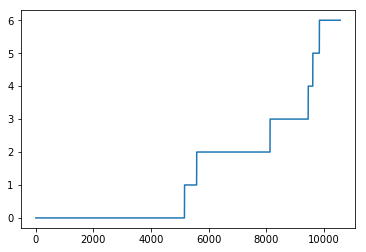

In [17]:
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])
y_data = np.asarray(drumLabels)
print("y_data.shape:", y_data.shape)
plt.figure()
plt.plot(y_data)

# Create ground truth color map

In [18]:
import itertools
def concatColors(segmentList, colorList):
    multiples = []
    #print segmentList, colorList
    for i in range(len(segmentList)):
        multiples.append([colorList[i]]*segmentList[i])
    return list(itertools.chain(*multiples))

colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']
drumLengths = [5158,422,2546,1324,159,228,723]
colorMap = concatColors(drumLengths, colors)

In [28]:
def computeSilCoeff(data, cluster_labels):
    silhouette_avg = silhouette_score(data, cluster_labels)
    print("The average silhouette_score is :", silhouette_avg)

def plotSampleSilCoeff(data, cluster_labels, title):
    fig, ax1 = plt.subplots()
    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    
    n_clusters = 7
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("Av. Sil Coeff:", silhouette_avg)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Evaluating TSNE

In [33]:
def get_scaled_tsne_embeddings(features, perplexity, iteration):
    embedding = TSNE(n_components=2,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

In [35]:
tnse_embeddings_mfccs = []
perplexities = [2, 5, 30, 50, 100]
iterations = [250, 500, 1000, 2000, 5000]
for i, perplexity in enumerate(perplexities):
    for j, iteration in enumerate(iterations):
        %time tsne_mfccs = get_scaled_tsne_embeddings(x_data_MFCC,perplexity,iteration)
        tnse_embeddings_mfccs.append(tsne_mfccs)

CPU times: user 4min 9s, sys: 16.4 s, total: 4min 26s
Wall time: 6min 22s
CPU times: user 5min 59s, sys: 29.4 s, total: 6min 29s
Wall time: 8min 59s
CPU times: user 9min 21s, sys: 55.4 s, total: 10min 17s
Wall time: 13min 19s
CPU times: user 19min 51s, sys: 60 s, total: 20min 51s
Wall time: 10min 49s
CPU times: user 43min 25s, sys: 2min 3s, total: 45min 28s
Wall time: 16min 5s
CPU times: user 3min 27s, sys: 7.1 s, total: 3min 34s
Wall time: 2min 1s
CPU times: user 5min 35s, sys: 15.1 s, total: 5min 50s
Wall time: 3min 24s
CPU times: user 8min 27s, sys: 34 s, total: 9min 1s
Wall time: 11min 25s
CPU times: user 13min 25s, sys: 1min 8s, total: 14min 34s
Wall time: 17min 51s
CPU times: user 37min 54s, sys: 2min 59s, total: 40min 53s
Wall time: 57min 39s
CPU times: user 5min 5s, sys: 11.4 s, total: 5min 16s
Wall time: 12min 50s
CPU times: user 7min 6s, sys: 21.1 s, total: 7min 27s
Wall time: 13min 24s
CPU times: user 10min 9s, sys: 35.6 s, total: 10min 45s
Wall time: 13min 51s


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(nrows=len(perplexities), 
                       ncols=len(iterations),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        col.scatter(tnse_embeddings_mfccs[current_plot].T[0], 
                    tnse_embeddings_mfccs[current_plot].T[1],
                    c=colorMap,
                    s=1)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=len(perplexities), 
                       ncols=len(iterations),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        plotSampleSilCoeff(tnse_embeddings_mfccs[current_plot], y_data, "TSNE MFCC")
plt.show()

# Fooling around with TSNE

In [19]:
tnse_embeddings_mfccs = []
#tnse_embeddings_wavenet = []
#perplexities = [2, 5, 30, 50, 100]
#iterations = [250, 500, 1000, 2000, 5000]
perplexities = [50]
iterations = [500]
for i, perplexity in enumerate(perplexities):
    for j, iteration in enumerate(iterations):
        %time tsne_mfccs = get_scaled_tsne_embeddings(x_data_MFCC,
                                                perplexity,
                                                iteration)
        '''
        tnse_wavenet = get_scaled_tsne_embeddings(wavenet_features,
                                                  perplexity,
                                                  iteration)
        '''
        tnse_embeddings_mfccs.append(tsne_mfccs)
        #tnse_embeddings_wavenet.append(tnse_wavenet)

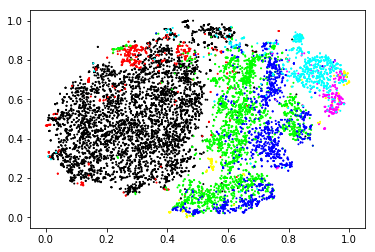

In [29]:
plt.scatter(tnse_embeddings_mfccs[0].T[0], 
                    tnse_embeddings_mfccs[0].T[1],
                    c=colorMap,
                    s=1)

('The average silhouette_score is :', 0.030415913)


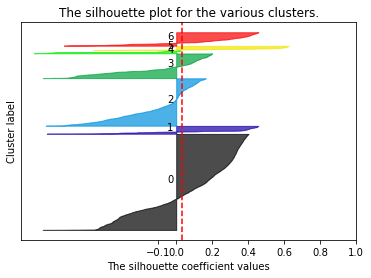

In [32]:
computeSilCoeff(tnse_embeddings_mfccs[0],y_data)
plotSampleSilCoeff(tnse_embeddings_mfccs[0], y_data, "TSNE MFCC")